In [1]:
%tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
1.15.0


In [2]:
pip install keras==2.2.4 # 需要安裝 keras 2.2.4 的版本

In [3]:
from google.colab import drive 
drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# 下載基於 keras 的 yolov3 程式碼
%cd 'gdrive/My Drive'
# !git clone https://github.com/qqwweee/keras-yolo3 # 如果之前已經下載過就可以註解掉
%cd keras-yolo3

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive
/content/gdrive/My Drive/keras-yolo3


In [4]:
import os
if not os.path.exists("model_data/yolo.h5"):
    # 下載 yolov3 的網路權重，並且把權重轉換為 keras 能夠讀取的格式
    print("Model doesn't exist, downloading...")
    os.system("wget https://pjreddie.com/media/files/yolov3.weights")
    print("Converting yolov3.weights to yolo.h5...")
    os.system("python convert.py yolov3.cfg yolov3.weights model_data/yolo.h5")
else:
    print("Model exist")

Model exist


In [0]:
import glob
import pandas as pd
import xml.etree.ElementTree as ET

In [0]:
def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [8]:
# 將annotations資料夾裡的xml轉換成csv檔
categories_list = ['raccoon', 'kangaroo']
categories_path = []
annotations_path = []
images_path = []

for i in range(len(categories_list)):
    categories_path.append(os.path.join('Day049-050/' + categories_list[i] + '/'))
    annotations_path.append(os.path.join('Day049-050/' + categories_list[i] + '/annotations/'))
    images_path.append(os.path.join('Day049-050/' + categories_list[i] + '/images/'))

for i in range(len(categories_list)):
    destination_path = categories_path[i] + categories_list[i] + '_labels.csv'
    if not os.path.exists(destination_path):
        xml_df = xml_to_csv(annotations_path[i])
        xml_df.to_csv(destination_path, index=None)
        print('Successfully converted ' + categories_list[i] + ' xml to csv.')
    else:
        print(categories_list[i] + '_labels.csv already exists')

raccoon_labels.csv already exists
kangaroo_labels.csv already exists


In [9]:
# 將資料格式轉為yolo3格式
destination_path = os.path.join(os.getcwd(), 'Day049-050/Day049-050_yolo3.txt')
if not os.path.exists(destination_path):
    yolo3_file = open(destination_path, 'w')
    for i in range(len(categories_list)):
        source_path = categories_path[i] + categories_list[i] + '_labels.csv'

        labels_file = open(source_path, 'r')
        labels_line = labels_file.readline() #讀取標題
            
        labels_line = labels_file.readline() #讀取第一筆資料
        data = labels_line[:-1].split(',')
        last_file_name = data[0]
        yolo3_file.write(images_path[i] + last_file_name + ' ' + data[4] + ',' + data[5] + ',' + data[6] + ',' + data[7] + ',' + str(i))

        while labels_line:
            labels_line = labels_file.readline()
            if labels_line == '':
                break
            data = labels_line[:-1].split(',')
            
            if last_file_name != data[0]:
                last_file_name = data[0]
                yolo3_file.write('\n')
                yolo3_file.write(images_path[i] + last_file_name + ' ' + data[4] + ',' + data[5] + ',' + data[6] + ',' + data[7] + ',' + str(i))
            else:
                yolo3_file.write(' ' + data[4] + ',' + data[5] + ',' + data[6] + ',' + data[7] + ',' + str(i))
        yolo3_file.write('\n')        
    yolo3_file.close()
    print('Successfully converted to Day049-050_yolo3.txt')
else:
    print('Day049-050_yolo3.txt already exists')

Day049-050_yolo3.txt already exists


In [10]:
# 將 train.py 所需要的套件載入
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

Using TensorFlow backend.


In [0]:
from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

In [12]:
if not os.path.exists("model_data/yolo_weights.h5"):
    print("Converting pretrained YOLOv3 weights for training")
    os.system("python convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5") 
else:
    print("Pretrained weights exists")

Pretrained weights exists


In [0]:
# 出現錯誤OSError: image file is truncated (25 bytes not processed) 增加以下部分
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [0]:
annotation_path = 'Day049-050/Day049-050_yolo3.txt' # 轉換好格式的標註檔案
log_dir = 'logs/000/' # 訓練好的模型儲存的路徑
classes_path = 'Day049-050/Day049-050_classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416,416) # multiple of 32, hw

In [15]:
is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/tiny_yolo_weights.h5')
else:
    model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/yolo_weights.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 分為 training 以及 validation
val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
if True:
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 16
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    # 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=50,
            initial_epoch=0,)
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')

# Unfreeze and continue training, to fine-tune.
# Train longer if the result is not good.
if True:
    # 把所有 layer 都改為 trainable
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')

    batch_size = 16 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=100,
        initial_epoch=50,
        callbacks=[reduce_lr, early_stopping])
    model.save_weights(log_dir + 'trained_weights_final.h5')














Create YOLOv3 model with 9 anchors and 2 classes.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 21) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 21) vs (255, 512, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_75 due to mismatch in shape ((1,

Load weights model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 328 samples, val on 36 samples, with batch size 16.


Epoch 1/50
20/20 [==============================] - 300s 15s/step - loss: 3785.1056 - val_loss: 946.3193
Epoch 2/50
20/20 [==============================] - 279s 14s/step - loss: 547.6949 - val_loss: 274.5667
Epoch 3/50
20/20 [==============================] - 278s 14s/step - loss: 240.0137 - val_loss: 173.9468
Epoch 4/50
20/20 [==============================] - 278s 14s/step - loss: 167.3866 - val_loss: 128.8022
Epoch 5/50
20/20 [==============================] - 276s 14s/step - loss: 128.1058 - val_loss: 109.0593
Epoch 6/50
20/20 [==============================] - 277s 14s/step - loss: 107.5036 - val_loss: 93.1818
Epoch 7/50
20/20 [==============================] - 277s 14s/step - loss: 90.7279 - val_loss: 83.2349
Epoch 8/50
20/20 [=======

In [15]:
from yolo import YOLO
yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path)













logs/000/trained_weights_final.h5 model, anchors, and classes loaded.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# 測試圖片
from PIL import Image
image_raccoon = Image.open(images_path[0] + 'raccoon-1.jpg')
image_kangaroo = Image.open(images_path[1] + '00014.jpg')

In [23]:
r_image_raccoon = yolo_model.detect_image(image_raccoon)
r_image_kangaroo = yolo_model.detect_image(image_kangaroo)

(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (70, 137) (557, 367)
2.4104286789997786
(416, 416, 3)
Found 5 boxes for img
kangaroo 0.40 (286, 165) (436, 291)
kangaroo 0.60 (322, 125) (406, 331)
kangaroo 0.80 (242, 82) (357, 233)
kangaroo 0.97 (0, 137) (326, 343)
kangaroo 0.98 (399, 25) (597, 307)
0.8597812250000061


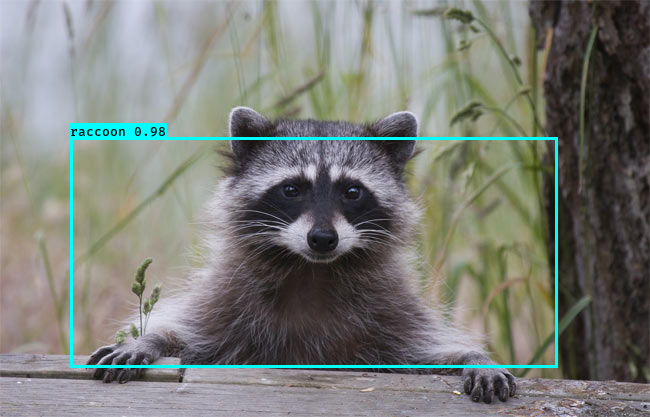

In [24]:
r_image_raccoon

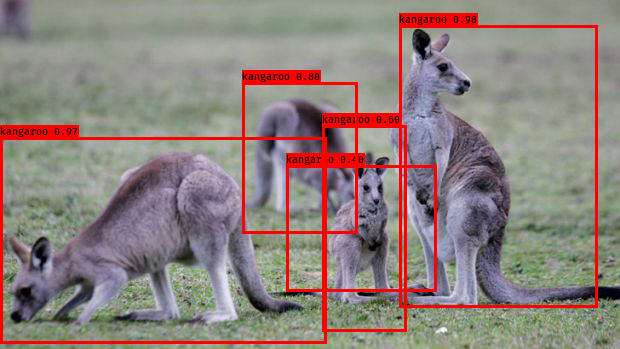

In [25]:
r_image_kangaroo

In [0]:
# 測試影片:兩個影片的誤判率都高
# 出現錯誤:the x window system is not available in colab -> 刪除yolo.py裡的cv2.imshow相關部分
# 出現錯誤:AttributeError: 'NoneType' object has no attribute '__array_interface__' -> 修改video_FourCC = cv2.VideoWriter_fourcc(*'XVID');return_value, frame = vid.read()後面增加if not return_value: break
def detect_video(yolo, video_path, output_path=""):
    #from timeit import default_timer as timer
    from PIL import Image
    import cv2
    vid = cv2.VideoCapture(video_path)
    if not vid.isOpened():
        raise IOError("Couldn't open webcam or video")
    #video_FourCC    = int(vid.get(cv2.CAP_PROP_FOURCC))
    video_FourCC = cv2.VideoWriter_fourcc(*'XVID')
    video_fps       = vid.get(cv2.CAP_PROP_FPS)
    video_size      = (int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)),
                        int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    isOutput = True if output_path != "" else False
    if isOutput:
        print("!!! TYPE:", type(output_path), type(video_FourCC), type(video_fps), type(video_size))
        out = cv2.VideoWriter(output_path, video_FourCC, video_fps, video_size)
    #accum_time = 0
    #curr_fps = 0
    #fps = "FPS: ??"
    #prev_time = timer()
    while True:
        return_value, frame = vid.read()
        # add
        if return_value == False:
            break
        # add
        image = Image.fromarray(frame)
        image = yolo.detect_image(image)
        result = np.asarray(image)
        #curr_time = timer()
        #exec_time = curr_time - prev_time
        #prev_time = curr_time
        #accum_time = accum_time + exec_time
        #curr_fps = curr_fps + 1
        #if accum_time > 1:
        #    accum_time = accum_time - 1
        #    fps = "FPS: " + str(curr_fps)
        #    curr_fps = 0
        #cv2.putText(result, text=fps, org=(3, 15), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        #            fontScale=0.50, color=(255, 0, 0), thickness=2)
        #cv2.namedWindow("result", cv2.WINDOW_NORMAL)
        #cv2.imshow("result", result)
        if isOutput:
            out.write(result)
        #if cv2.waitKey(1) & 0xFF == ord('q'):
        #    break
    #yolo.close_session()

In [26]:
video_raccoon_path = os.path.join(categories_path[0] + 'Raccoon.mp4')
video_raccoon_output_path = os.path.join(categories_path[0] + 'Raccoon_output.mp4')
r_video_raccoon = detect_video(yolo_model, video_raccoon_path, video_raccoon_output_path)

Streaming output truncated to the last 5000 lines.
0.945244131000436
(416, 416, 3)
Found 0 boxes for img
0.9295646239988855
(416, 416, 3)
Found 0 boxes for img
0.9490236330002517
(416, 416, 3)
Found 0 boxes for img
0.9253519090016198
(416, 416, 3)
Found 0 boxes for img
0.934721872999944
(416, 416, 3)
Found 0 boxes for img
0.9445033319989307
(416, 416, 3)
Found 0 boxes for img
0.9170551889983471
(416, 416, 3)
Found 0 boxes for img
0.8846623650006222
(416, 416, 3)
Found 0 boxes for img
0.908445799999754
(416, 416, 3)
Found 0 boxes for img
0.907124767998539
(416, 416, 3)
Found 0 boxes for img
0.9162172630003624
(416, 416, 3)
Found 0 boxes for img
0.9078131149999535
(416, 416, 3)
Found 0 boxes for img
0.9110615469999175
(416, 416, 3)
Found 0 boxes for img
0.9106201560007321
(416, 416, 3)
Found 1 boxes for img
raccoon 0.39 (111, 0) (1142, 622)
0.9134125170003244
(416, 416, 3)
Found 0 boxes for img
0.9121352389993262
(416, 416, 3)
Found 0 boxes for img
0.9069778659995791
(416, 416, 3)
Found 

In [17]:
video_kangaroo_path = os.path.join(categories_path[1] + 'Kangaroo.mp4')
video_kangaroo_output_path = os.path.join(categories_path[1] + 'kangaroo_output.mp4')
r_video_kangaroo = detect_video(yolo_model, video_kangaroo_path, video_kangaroo_output_path)

Streaming output truncated to the last 5000 lines.
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.92 (131, 256) (951, 618)
0.8593470109990449
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.91 (137, 257) (945, 618)
0.8556106999985786
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.35 (301, 302) (806, 586)
kangaroo 0.85 (118, 248) (970, 626)
0.8735043809992931
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.58 (129, 318) (535, 584)
kangaroo 0.87 (356, 250) (917, 648)
0.8539994339989789
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.87 (97, 286) (459, 636)
kangaroo 0.88 (386, 244) (942, 660)
0.8502574029989773
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.54 (529, 325) (896, 637)
kangaroo 0.96 (348, 266) (994, 678)
kangaroo 0.96 (68, 265) (432, 667)
0.8673857250014407
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.52 (528, 324) (896, 638)
kangaroo 0.96 (346, 267) (995, 677)
kangaroo 0.96 (69, 264) (430, 667)
0.851909760000126
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.93 (58, 238) (435

In [0]:
yolo_model.close_session()